In [54]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
from scipy.stats import qmc
import tensorflow as tf
import keras
from keras import layers


import explainabilityModels

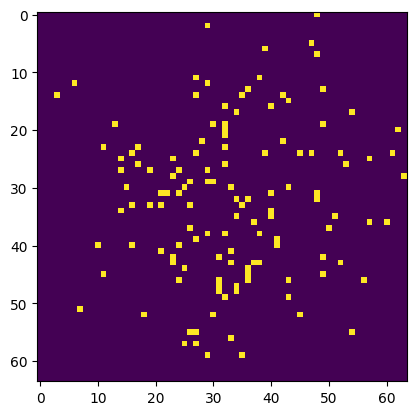

In [323]:
norm = np.random.standard_normal(size=(128,2))
norm = (63*(norm-np.min(norm))/np.ptp(norm)).astype('uint8')
norm.max()
img = np.zeros([64,64])
for i in range(128):
    img[norm[i][0], norm[i][1]] = 1
plt.imshow(img)

In [330]:
def generate_pseudo_img(n_pts = 128, size = 64):
    img = np.zeros([size,size])
    for i in range(n_pts):
        pt = np.random.randint(0, size, size =  (2,1))
        while img[pt[0], pt[1]] == 1:
            pt = np.random.randint(0, size, size =  (2,1))
        img[pt[0], pt[1]] = 1
    return img

def generate_quasi_img(n_exp = 7, size = 64, n_pts = 128):
    sobol = qmc.Sobol(d = 2)
    sample = sobol.random_base2(m=7)
    sample = np.floor(size*sample).astype('uint8')
    qmc_img = np.zeros([size,size])
    for i in range(n_pts):
        qmc_img[sample[i][0], sample[i][1]] = 1
    return qmc_img

def generate_2d_power(n_pts = 128, size = 64, pow = 3):
    power_dist = np.random.power(pow, size=(n_pts, 2))
    power_dist = np.floor(size*power_dist).astype('uint8')
    pow_img = np.zeros([size,size])
    for i in range(n_pts):
        pow_img[power_dist[i][0], power_dist[i][1]] = 1
    return pow_img

def generate_2d_normal(n_pts = 128, size = 64):
    norm = np.random.standard_normal(size=(n_pts,2))
    norm = ((size-1)*(norm-np.min(norm))/np.ptp(norm)).astype('uint8')
    img = np.zeros([size,size])
    for i in range(n_pts):
        img[norm[i][0], norm[i][1]] = 1
    return img



In [331]:
#hyperparameters and blank image and label generation
N = 6000
n_exp = 7
n_pts = 2**7
size = 64
labels = np.random.randint(4, size = N)
imgs = np.zeros((size, size, N))


In [332]:
#fill array with corresponding images
from tqdm import tqdm
for i in tqdm(range(N)):
    if labels[i] == 0:
        x = generate_quasi_img(n_exp=n_exp, size=size, n_pts=n_pts)
    elif labels[i] == 1:
        x = generate_pseudo_img(n_pts=n_pts, size=size)
    elif labels[i] == 2:
        x = generate_2d_power(n_pts=n_pts, size=size, pow = 1.5)
    elif labels[i] == 3:
        x = generate_2d_normal(n_pts=n_pts, size = size)
    imgs[:,:,i] = x

100%|██████████| 6000/6000 [00:03<00:00, 1550.27it/s]


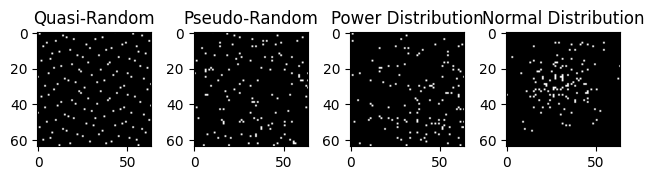

In [334]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,4)

quasi_img = imgs[:,:,np.where(labels == 0)[0][0]]
pseudo_img = imgs[:,:,np.where(labels ==1)[0][0]]
pow_img = imgs[:,:,np.where(labels ==2)[0][0]]
normal_img = imgs[:,:,np.where(labels ==3)[0][0]]

ax[0].imshow(quasi_img, cmap=plt.cm.gray)
ax[1].imshow(pseudo_img, cmap=plt.cm.gray)
ax[2].imshow(pow_img, cmap='gray')
ax[3].imshow(normal_img, cmap ='gray')

ax[0].set_title("Quasi-Random");
ax[1].set_title("Pseudo-Random");
ax[2].set_title("Power Distribution");
ax[3].set_title('Normal Distribution');

fig.tight_layout()


In [335]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(6000, 64, 64, 1)

In [369]:
# Model hyperparameters
num_classes = 4
input_shape = (size, size, 1)
batch_size = 64
epochs = 30
conv_size=(3,3)
save = True
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [370]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_17 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                      

In [371]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/30
57/57 [==============================] - 1s 16ms/step - loss: 0.2815 - accuracy: 0.9237 - val_loss: 7.8726 - val_accuracy: 0.2612
Epoch 2/30
57/57 [==============================] - 1s 14ms/step - loss: 0.0091 - accuracy: 0.9964 - val_loss: 18.2131 - val_accuracy: 0.2612
Epoch 3/30
57/57 [==============================] - 1s 14ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 22.3390 - val_accuracy: 0.2612
Epoch 4/30
57/57 [==============================] - 1s 14ms/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 26.5014 - val_accuracy: 0.2612
Epoch 5/30
57/57 [==============================] - 1s 14ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 27.3797 - val_accuracy: 0.2612
Epoch 6/30
57/57 [==============================] - 1s 14ms/step - loss: 3.3508e-04 - accuracy: 1.0000 - val_loss: 25.4462 - val_accuracy: 0.2612
Epoch 7/30
57/57 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 0.9989 - val_loss: 24.8849 - val_accuracy: 0.2612
Epo

In [417]:
if save:
    model.save("models/model30_distro")

INFO:tensorflow:Assets written to: models/model30_distro\assets


INFO:tensorflow:Assets written to: models/model30_distro\assets


In [10]:
model = tf.keras.models.load_model("models/model30_distro")

In [372]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Quasi-Random', 'Pseudo-Random', 'Power Distribution', 'Normal Distribution']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.014666678383946419
Test accuracy: 0.9984848499298096
62/62 [==============================] - 0s 3ms/step
                     precision    recall  f1-score   support

       Quasi-Random       1.00      1.00      1.00       471
      Pseudo-Random       1.00      1.00      1.00       486
 Power Distribution       1.00      1.00      1.00       531
Normal Distribution       1.00      1.00      1.00       492

           accuracy                           1.00      1980
          macro avg       1.00      1.00      1.00      1980
       weighted avg       1.00      1.00      1.00      1980



In [373]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('Quasi-Random', 0), ('Pseudo-Random', 1), ('Power Distribution', 2), ('Normal Distribution', 3)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Quasi-Random', 0), ('Pseudo-Random', 1), ('Power Distribution', 2), ('Normal Distribution', 3)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


62/62 [==============================] - 0s 3ms/step


Dropdown(description='True Label:', options=(('Quasi-Random', 0), ('Pseudo-Random', 1), ('Power Distribution',…

Dropdown(description='Predicted Label:', options=(('Quasi-Random', 0), ('Pseudo-Random', 1), ('Power Distribut…

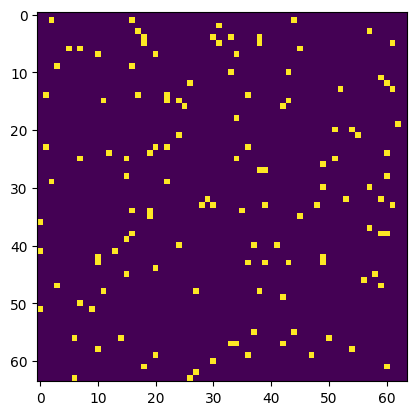

In [414]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][5]]
label = pred_picker.value
plt.imshow(img)

In [415]:
heatmap = explainabilityModels.make_gradcam_heatmap(img, model)

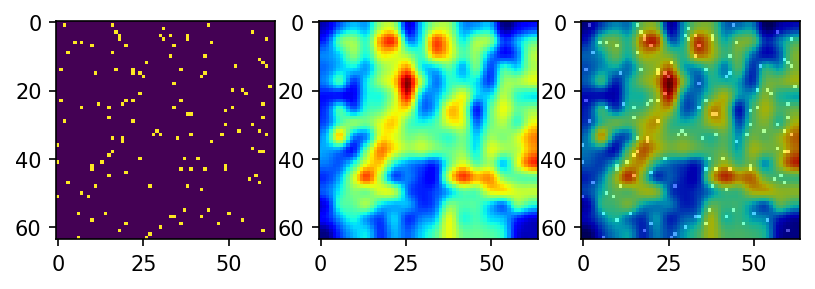

In [416]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(150)
fig.tight_layout

ax[0].imshow(img)
ax[1].imshow(heatmap, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray')
ax[2].imshow(heatmap, alpha = 0.7, cmap='jet')


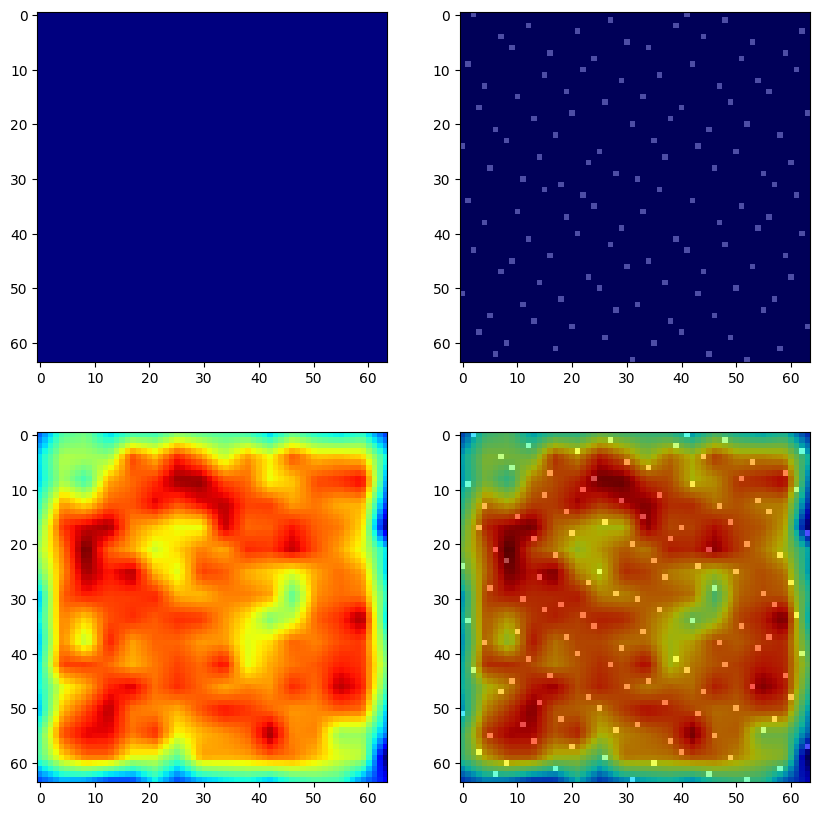

In [380]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), 
            clone=True)
gradcam2 = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(CategoricalScore(label), img).squeeze()
cam2 = gradcam2(CategoricalScore(label), img).squeeze()

fig, ax = plt.subplots(2,2)
fig.set_size_inches((10,10))
ax[0][0].imshow(cam, cmap = 'jet')
ax[0][1].imshow(img, cmap = 'gray')
ax[0][1].imshow(cam, cmap = 'jet', alpha = 0.7)

ax[1][0].imshow(cam2, cmap = 'jet')
ax[1][1].imshow(img, cmap = 'gray')
ax[1][1].imshow(cam2, cmap = 'jet', alpha = 0.7)


2/2 [==============================] - 0s 33ms/step


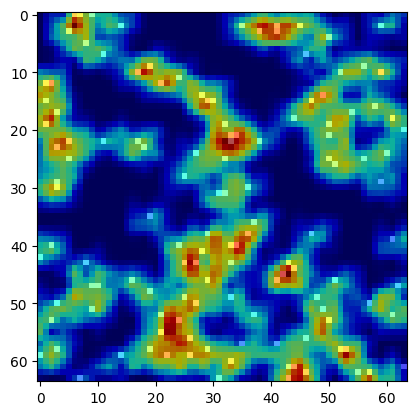

In [364]:
from tf_keras_vis.scorecam import Scorecam

scoreCam = Scorecam(model)

sC = scoreCam(CategoricalScore(label), img).squeeze()

plt.imshow(img, cmap = 'gray')
plt.imshow(sC, cmap = 'jet', alpha = 0.7)